## 発現変動遺伝子解析 (DEseq2) の結果をMA plotとして可視化する
`DESeq2`で検出された発現変動遺伝子について解析。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# color-blind safe color scheme from https://personal.sron.nl/~pault/#fig:scheme_bright
blue, cyan, green, yellow = "#4477AA", "#66CCEE", "#228833", "#CCBB44"
red, purple, grey, black = "#EE6677", "#AA3377", "#BBBBBB", "#333333"

### CPMで相関係数を計算する

In [4]:
# counts per million
def normalized_cpm(df_target, df_used):
    return 10 ** 6 * df_target / df_used.sum()

In [5]:
samples = ["DMSO-Total-1", "DMSO-Total-2", "DMSO-Total-3", "TPG-Total-1", "TPG-Total-2", "TPG-Total-3",
                    "DMSO-P0-1", "DMSO-P0-2", "DMSO-P0-3", "TPG-P0-1", "TPG-P0-2", "TPG-P0-3",
                    "DMSO-L10a-1", "DMSO-L10a-2", "DMSO-L10a-3", "TPG-L10a-1", "TPG-L10a-2", "TPG-L10a-3"]

df = pd.read_csv("../slamdunk/csv/allreads.csv", index_col="Name").drop(["Chromosome", "Start", "End", "Length", "Strand"], axis=1)
df.columns = samples

df_cpm = normalized_cpm(df, df)  # CPM正規化
df_cpm.head()

,DMSO-Total-1,DMSO-Total-2,DMSO-Total-3,TPG-Total-1,TPG-Total-2,TPG-Total-3,DMSO-P0-1,DMSO-P0-2,DMSO-P0-3,TPG-P0-1,TPG-P0-2,TPG-P0-3,DMSO-L10a-1,DMSO-L10a-2,DMSO-L10a-3,TPG-L10a-1,TPG-L10a-2,TPG-L10a-3
Name,,,,,,,,,,,,,,,,,,
OR4F5|ENSG00000186092.7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SAMD11|ENSG00000187634.13,194.403243,160.185979,173.713585,218.893622,207.731563,205.830403,233.105388,221.806801,226.708269,255.687486,259.561858,221.732985,153.680679,86.077881,185.036978,195.577994,119.844149,134.963490
NOC2L|ENSG00000188976.11,161.883143,146.541518,147.832699,143.771090,135.093808,140.199451,131.985560,163.209238,162.764911,273.298045,189.905075,163.533760,141.682646,87.158357,118.629664,174.926901,113.035882,117.577607
KLHL17|ENSG00000187961.15,11.238564,6.140008,10.433655,15.268807,14.527551,19.209059,8.868140,7.230789,9.203968,8.359443,12.834792,13.640443,3.881716,7.803434,7.679757,14.698719,6.715003,8.804390
PLEKHN1|ENSG00000187583.11,1.315151,1.364446,1.761526,0.488602,0.000000,0.266792,0.000000,0.375625,0.000000,1.560429,0.249219,0.000000,0.264662,0.960423,0.180700,7.045667,1.025903,0.891584


In [6]:
# 発現の低い遺伝子を除去
df_cpm["low"] = df_cpm.apply(lambda s: (s < 20).sum(), axis=1)
df_cpm = df_cpm[df_cpm["low"] ==0]
df_cpm = df_cpm.drop(labels="low", axis=1)

In [7]:
df_cpm 

,DMSO-Total-1,DMSO-Total-2,DMSO-Total-3,TPG-Total-1,TPG-Total-2,TPG-Total-3,DMSO-P0-1,DMSO-P0-2,DMSO-P0-3,TPG-P0-1,TPG-P0-2,TPG-P0-3,DMSO-L10a-1,DMSO-L10a-2,DMSO-L10a-3,TPG-L10a-1,TPG-L10a-2,TPG-L10a-3
Name,,,,,,,,,,,,,,,,,,
SAMD11|ENSG00000187634.13,194.403243,160.185979,173.713585,218.893622,207.731563,205.830403,233.105388,221.806801,226.708269,255.687486,259.561858,221.732985,153.680679,86.077881,185.036978,195.577994,119.844149,134.963490
NOC2L|ENSG00000188976.11,161.883143,146.541518,147.832699,143.771090,135.093808,140.199451,131.985560,163.209238,162.764911,273.298045,189.905075,163.533760,141.682646,87.158357,118.629664,174.926901,113.035882,117.577607
HES4|ENSG00000188290.11,136.656154,128.394384,108.537115,153.298826,139.812158,155.940208,212.605013,195.137398,200.670727,144.339710,150.154603,105.031414,157.562395,126.175527,129.019924,125.242802,122.362275,138.641273
SDF4|ENSG00000078808.20,341.102369,309.047056,316.668211,303.421740,292.289360,303.876642,343.554037,394.594487,364.283372,325.795345,290.589655,350.407834,316.095219,311.296996,336.554073,273.201806,261.045737,286.644176
B3GALT6|ENSG00000176022.7,168.219780,143.266847,149.729728,164.780969,155.581380,162.343228,146.842574,145.648751,112.748610,137.540697,116.011565,123.067111,142.476634,123.054154,147.903092,135.082440,120.123940,146.108287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEPTIN6|ENSG00000125354.24,155.187829,148.588187,155.285310,144.748294,145.027176,150.604358,129.912489,130.435922,120.499320,117.700953,120.622121,110.790712,131.890135,137.820652,137.964582,154.518763,159.854374,161.711003
THOC2|ENSG00000125676.20,90.506307,92.918784,112.873179,103.827890,84.557797,86.440765,39.849044,36.717383,35.483719,38.230518,58.566526,31.069899,47.021700,48.381292,45.626794,50.291484,67.336557,51.266066
ATP11C|ENSG00000101974.15,63.007693,66.039194,73.848599,71.213717,74.376094,76.302651,32.132610,34.651444,31.850574,32.211719,23.302001,23.643435,29.642198,45.500024,36.049685,37.657875,34.134598,33.880183


In [8]:
log2_cpm = df_cpm.copy()
log2_cpm = np.log2(log2_cpm)
log2_cpm

,DMSO-Total-1,DMSO-Total-2,DMSO-Total-3,TPG-Total-1,TPG-Total-2,TPG-Total-3,DMSO-P0-1,DMSO-P0-2,DMSO-P0-3,TPG-P0-1,TPG-P0-2,TPG-P0-3,DMSO-L10a-1,DMSO-L10a-2,DMSO-L10a-3,TPG-L10a-1,TPG-L10a-2,TPG-L10a-3
Name,,,,,,,,,,,,,,,,,,
SAMD11|ENSG00000187634.13,7.602908,7.323604,7.440567,7.774086,7.698577,7.685312,7.864839,7.793160,7.824693,7.998238,8.019935,7.792680,7.263792,6.427571,7.531670,7.611600,6.905016,7.076425
NOC2L|ENSG00000188976.11,7.338809,7.195166,7.207822,7.167630,7.077818,7.131337,7.044236,7.350579,7.346646,8.094331,7.569135,7.353445,7.146519,6.445567,6.890321,7.450608,6.820637,6.877470
HES4|ENSG00000188290.11,7.094407,7.004438,6.762045,7.260203,7.127346,7.284849,7.732032,7.608346,7.648686,7.173324,7.230305,6.714677,7.299779,6.979288,7.011450,6.968584,6.935015,7.115213
SDF4|ENSG00000078808.20,8.414061,8.271683,8.306828,8.245181,8.191254,8.247342,8.424393,8.624227,8.508917,8.347822,8.182840,8.452891,8.304215,8.282148,8.394695,8.093823,8.028159,8.163117
B3GALT6|ENSG00000176022.7,7.394204,7.162561,7.226217,7.364406,7.281526,7.342903,7.198126,7.186350,6.816966,7.103715,6.858125,6.943301,7.154582,6.943150,7.208508,7.077696,6.908380,7.190894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEPTIN6|ENSG00000125354.24,7.277872,7.215176,7.278778,7.177403,7.180179,7.234620,7.021396,7.027197,6.912881,6.878982,6.914351,6.791693,7.043193,7.106648,7.108154,7.271638,7.320614,7.337274
THOC2|ENSG00000125676.20,6.499946,6.537898,6.818559,6.698050,6.401866,6.433640,5.316473,5.198391,5.149085,5.256653,5.872004,4.957446,5.555255,5.596377,5.511809,5.652242,6.073318,5.679932
ATP11C|ENSG00000101974.15,5.977456,6.045251,6.206499,6.154083,6.216767,6.253661,5.005966,5.114844,4.993247,5.009514,4.542382,4.563368,4.889580,5.507795,5.171915,5.234880,5.093163,5.082370


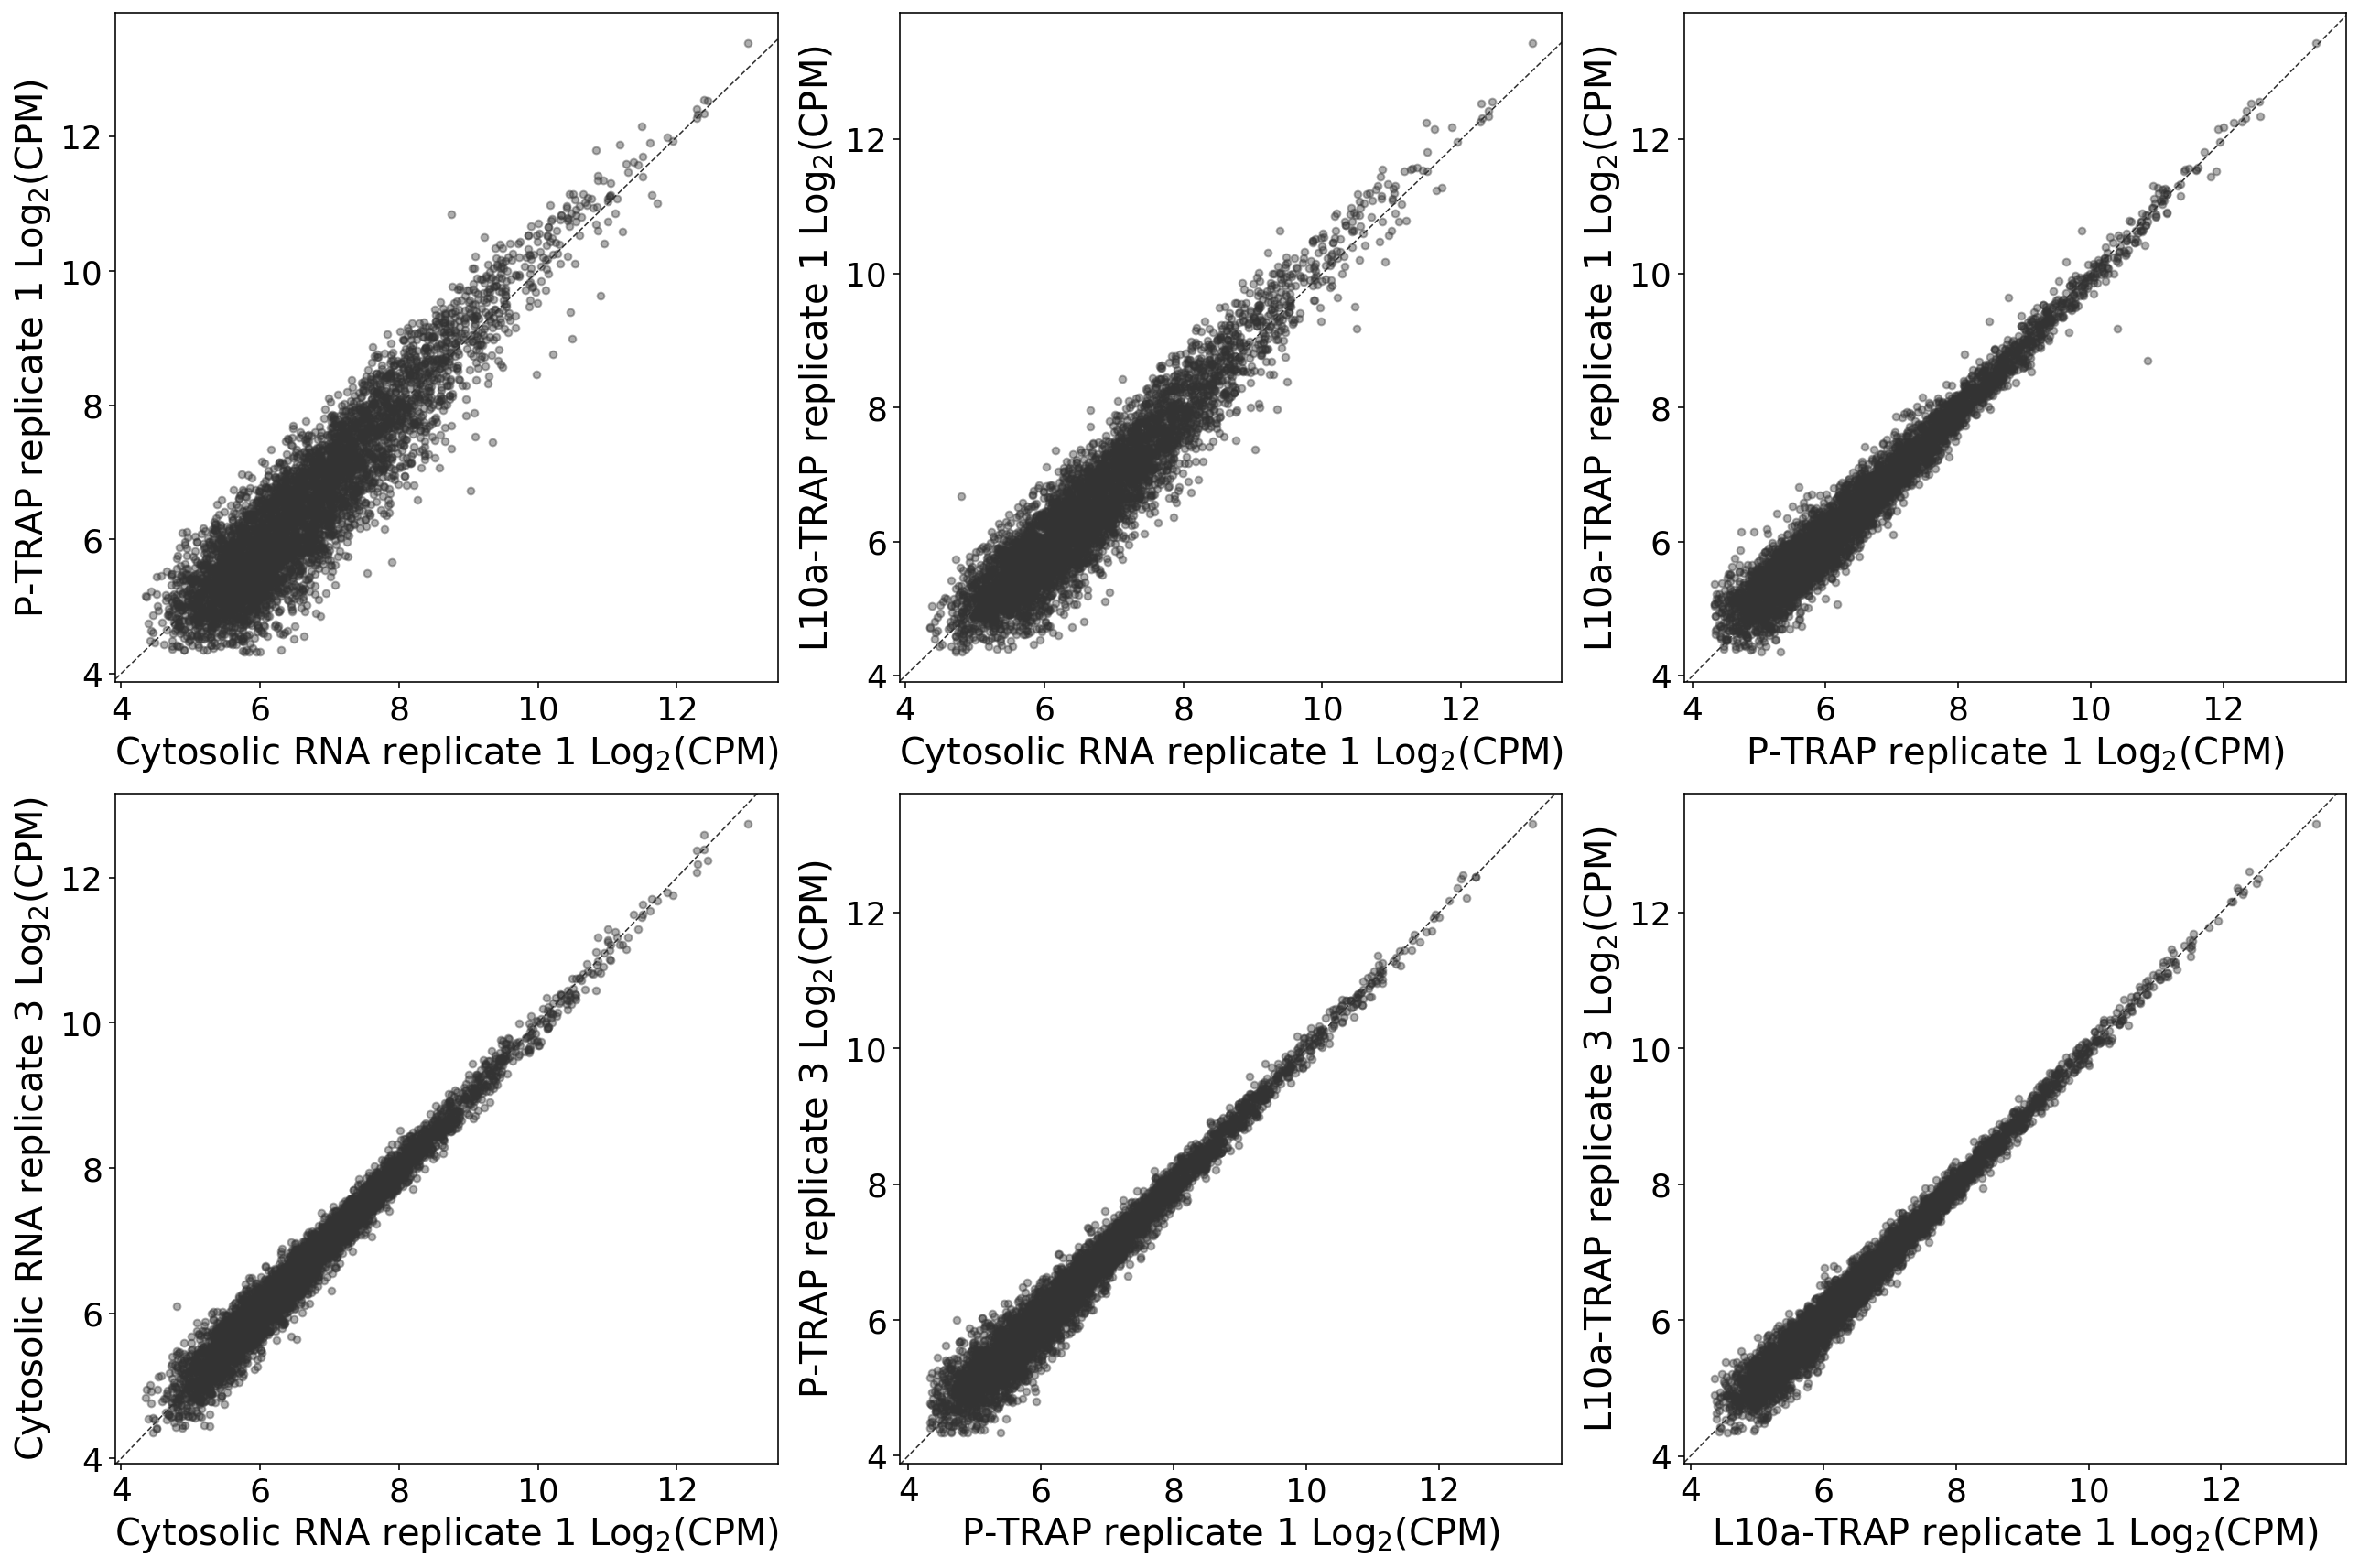

In [9]:
fig = plt.figure(figsize=(18, 12), tight_layout=True)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

color = {"up":red, "down":cyan, "ns":black}

sample_set_1 = ["DMSO-Total-1", "DMSO-Total-1", "DMSO-P0-1", "DMSO-Total-1", "DMSO-P0-1", "DMSO-L10a-1"]
sample_set_2 = ["DMSO-P0-1", "DMSO-L10a-1", "DMSO-L10a-1", "DMSO-Total-3", "DMSO-P0-3", "DMSO-L10a-3"]

for data1, data2, ax in zip((sample_set_1), (sample_set_2), (ax1, ax2, ax3, ax4, ax5, ax6)):
    ax.scatter(log2_cpm[data1], log2_cpm[data2], color=black, alpha=0.4, s=15)
    
    ax.tick_params(direction="out", labelsize=18)
    x = y = list(ax.get_xlim())
    ax.plot(x, y, linestyle="--", color=black, lw=0.8, scalex=False, scaley=False)
    
ax1.set_xlabel("Cytosolic RNA replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax1.set_ylabel("P-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)

ax2.set_xlabel("Cytosolic RNA replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax2.set_ylabel("L10a-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)

ax3.set_xlabel("P-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax3.set_ylabel("L10a-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)

ax4.set_xlabel("Cytosolic RNA replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax4.set_ylabel("Cytosolic RNA replicate 3 Log$_{2}$(CPM)", fontsize=20)

ax5.set_xlabel("P-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax5.set_ylabel("P-TRAP replicate 3 Log$_{2}$(CPM)", fontsize=20)

ax6.set_xlabel("L10a-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax6.set_ylabel("L10a-TRAP replicate 3 Log$_{2}$(CPM)", fontsize=20)            

fig.savefig("../results/figure_S3/ScatterPlot_DMSO_ReadCount.pdf", bbox_inches="tight", transparent=True)

In [11]:
print(stats.spearmanr(log2_cpm["DMSO-Total-1"], log2_cpm["DMSO-P0-1"]).correlation)
print(stats.spearmanr(log2_cpm["DMSO-Total-1"], log2_cpm["DMSO-L10a-1"]).correlation)
print(stats.spearmanr(log2_cpm["DMSO-P0-1"], log2_cpm["DMSO-L10a-1"]).correlation)
print(stats.spearmanr(log2_cpm["DMSO-Total-1"], log2_cpm["DMSO-Total-3"]).correlation)
print(stats.spearmanr(log2_cpm["DMSO-P0-1"], log2_cpm["DMSO-P0-3"]).correlation)
print(stats.spearmanr(log2_cpm["DMSO-L10a-1"], log2_cpm["DMSO-L10a-3"]).correlation)

0.8907090435665908
0.9242568562083203
0.9687587588857592
0.9810161605339285
0.9722598259398899
0.9830138503938979


TPG処理時

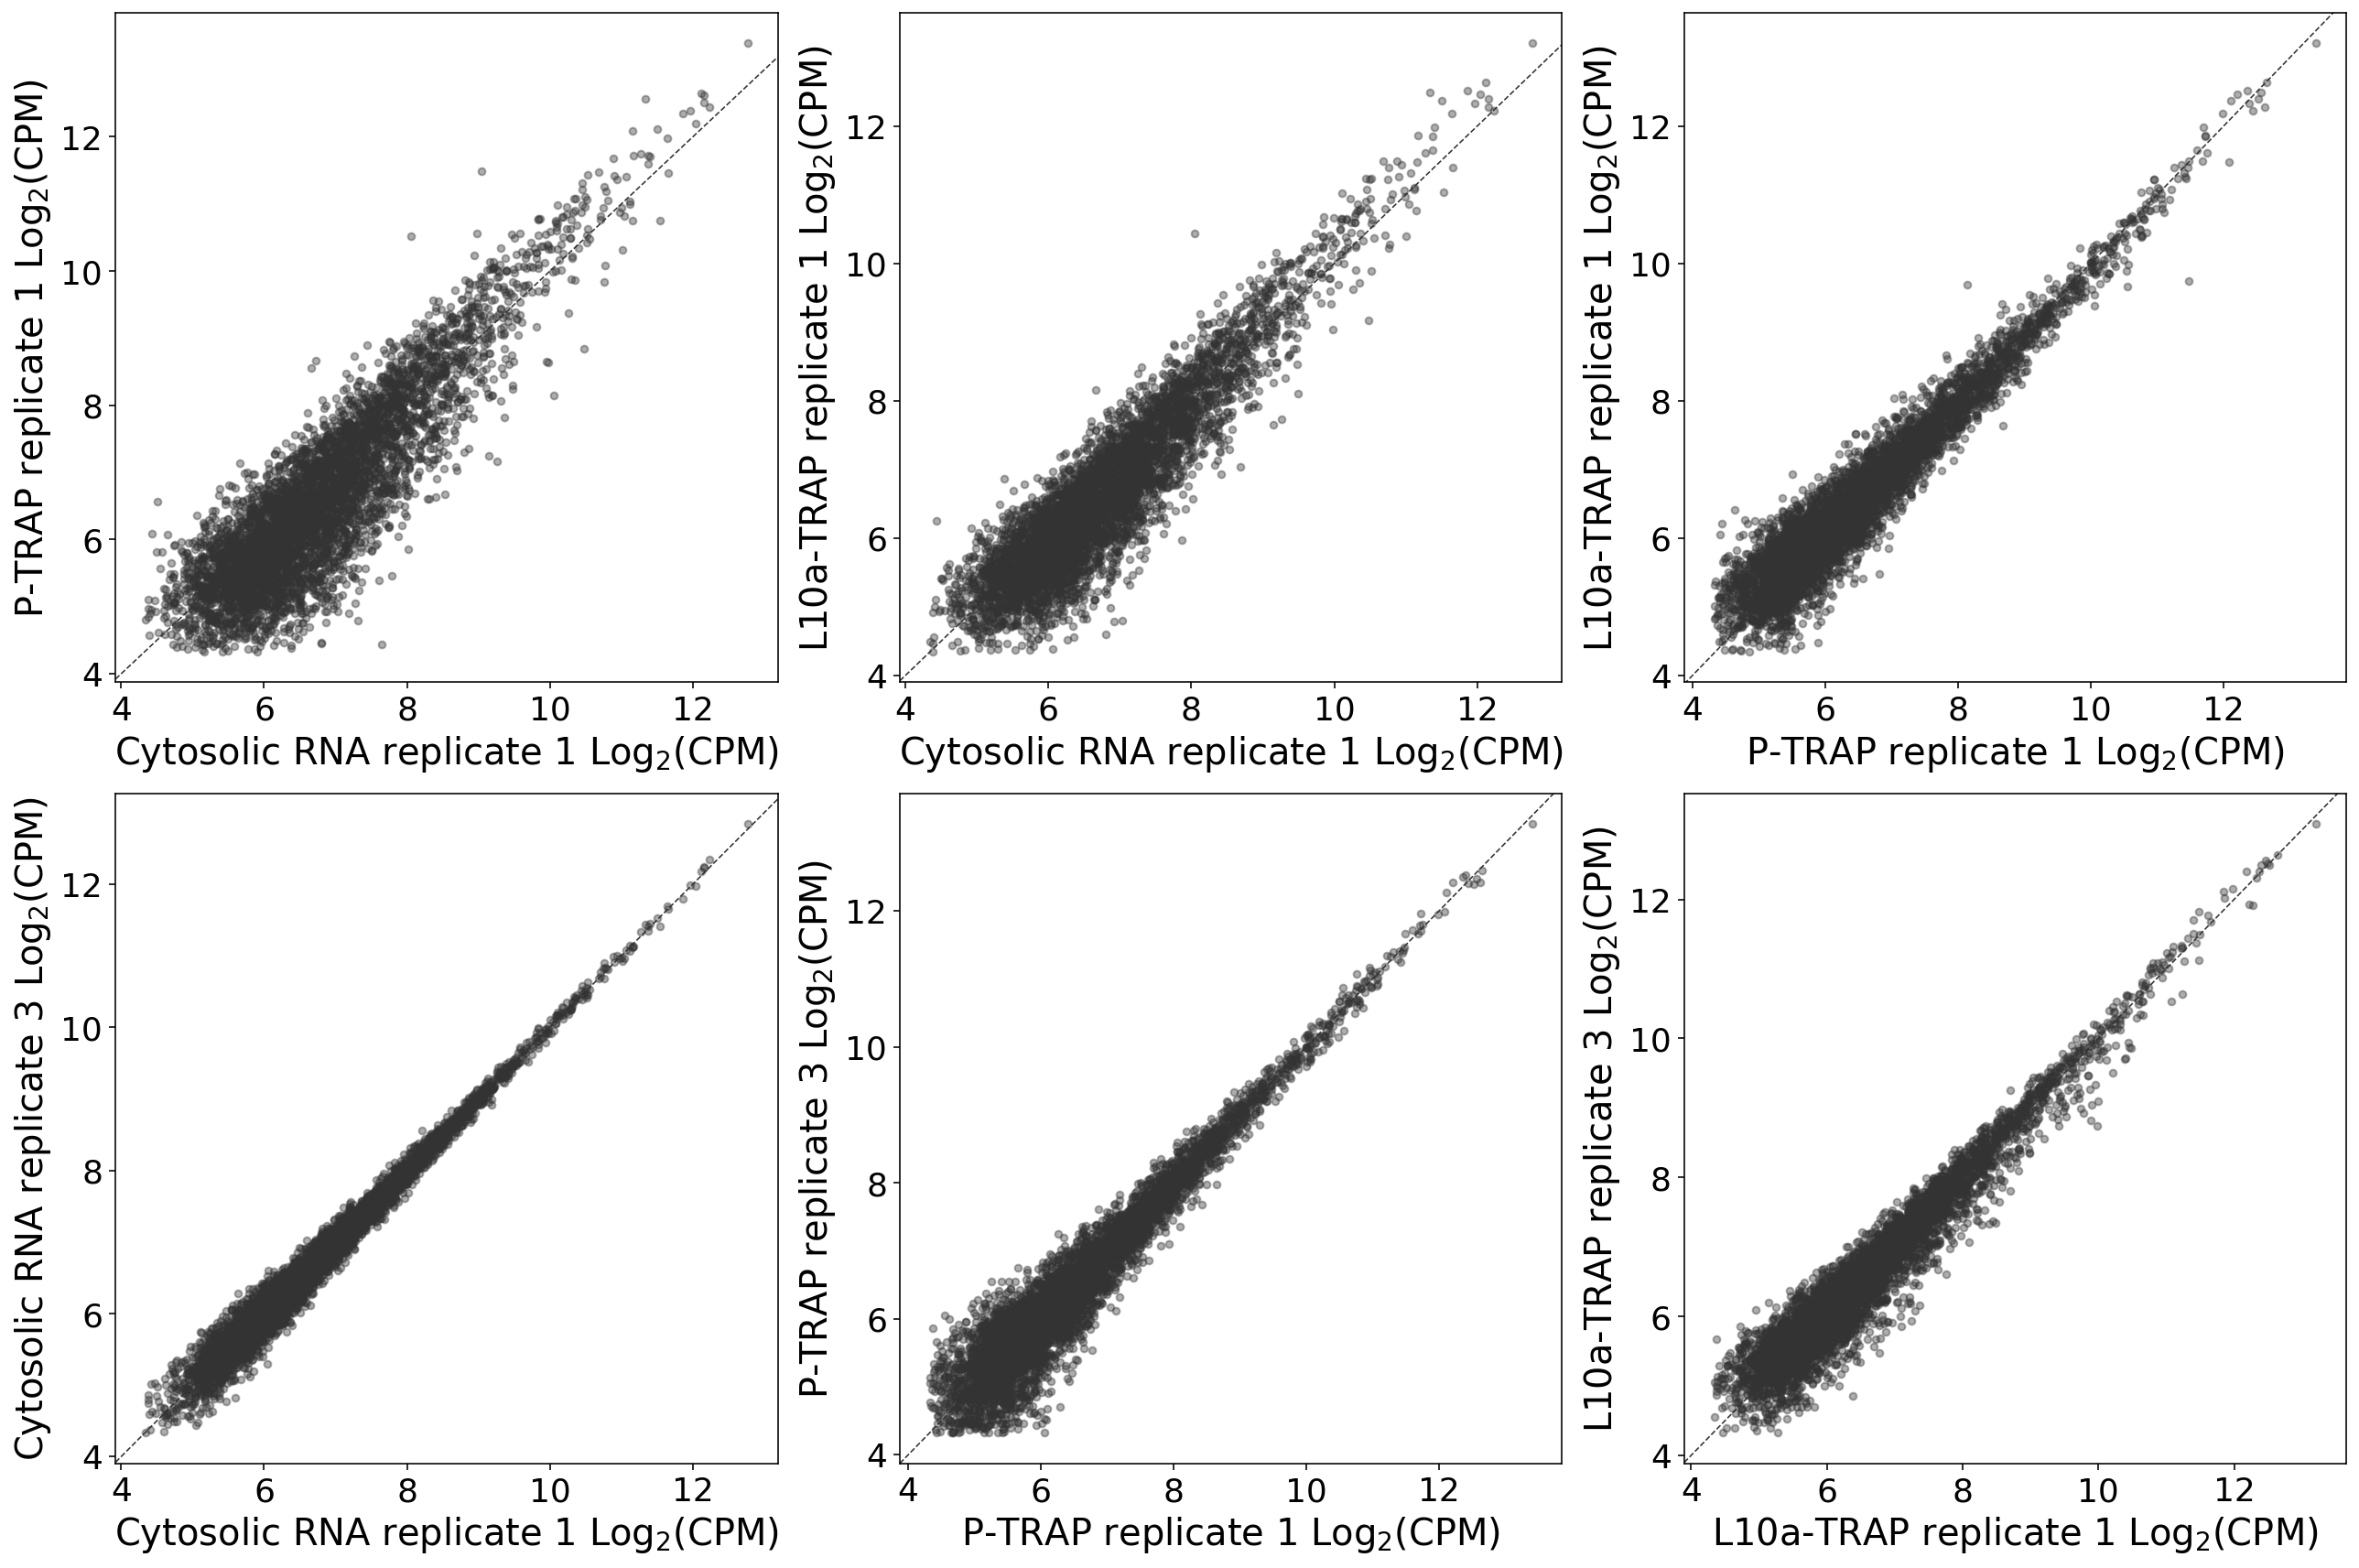

In [12]:
fig = plt.figure(figsize=(18, 12), tight_layout=True)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

color = {"up":red, "down":cyan, "ns":black}

sample_set_1 = ["TPG-Total-1", "TPG-Total-1", "TPG-P0-1", "TPG-Total-1", "TPG-P0-1", "TPG-L10a-1"]
sample_set_2 = ["TPG-P0-1", "TPG-L10a-1", "TPG-L10a-1", "TPG-Total-3", "TPG-P0-3", "TPG-L10a-3"]

for data1, data2, ax in zip((sample_set_1), (sample_set_2), (ax1, ax2, ax3, ax4, ax5, ax6)):
    ax.scatter(log2_cpm[data1], log2_cpm[data2], color=black, alpha=0.4, s=15)
    
    ax.tick_params(direction="out", labelsize=18)
    x = y = list(ax.get_xlim())
    ax.plot(x, y, linestyle="--", color=black, lw=0.8, scalex=False, scaley=False)
    
ax1.set_xlabel("Cytosolic RNA replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax1.set_ylabel("P-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)

ax2.set_xlabel("Cytosolic RNA replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax2.set_ylabel("L10a-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)

ax3.set_xlabel("P-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax3.set_ylabel("L10a-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)

ax4.set_xlabel("Cytosolic RNA replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax4.set_ylabel("Cytosolic RNA replicate 3 Log$_{2}$(CPM)", fontsize=20)

ax5.set_xlabel("P-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax5.set_ylabel("P-TRAP replicate 3 Log$_{2}$(CPM)", fontsize=20)

ax6.set_xlabel("L10a-TRAP replicate 1 Log$_{2}$(CPM)", fontsize=20)
ax6.set_ylabel("L10a-TRAP replicate 3 Log$_{2}$(CPM)", fontsize=20)            

fig.savefig("../results/figure_S3/ScatterPlot_TPG_ReadCount.pdf", bbox_inches="tight", transparent=True)

In [13]:
print(stats.spearmanr(log2_cpm["TPG-Total-1"], log2_cpm["TPG-P0-1"]).correlation)
print(stats.spearmanr(log2_cpm["TPG-Total-1"], log2_cpm["TPG-L10a-1"]).correlation)
print(stats.spearmanr(log2_cpm["TPG-P0-1"], log2_cpm["TPG-L10a-1"]).correlation)
print(stats.spearmanr(log2_cpm["TPG-Total-1"], log2_cpm["TPG-Total-3"]).correlation)
print(stats.spearmanr(log2_cpm["TPG-P0-1"], log2_cpm["TPG-P0-3"]).correlation)
print(stats.spearmanr(log2_cpm["TPG-L10a-1"], log2_cpm["TPG-L10a-3"]).correlation)

0.8407919618832956
0.8927285084550447
0.9417620810908088
0.9848134947549424
0.9389617994959492
0.9508012248358423
